# Proyecto 2 - HDT 9

Diego García 22404 <br>
César López 22535 <br>

GitHub: https://github.com/DiegoGarV/HDT9-DM 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import random
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier, MLPRegressor


In [3]:
train = pd.read_csv("train.csv")

In [4]:
mean_price = train['SalePrice'].mean()
std_price = train['SalePrice'].std()

low_price = mean_price - std_price
mid_price = mean_price + std_price

def categorizar_casas(precio):
    if precio <= low_price:
        return "Barata"
    elif precio <= mid_price:
        return "Normal"
    else:
        return "Cara"

train['Categoria'] = train['SalePrice'].apply(categorizar_casas)
train['Categoria'].value_counts()

Categoria
Normal    1145
Cara       191
Barata     124
Name: count, dtype: int64

In [5]:
columnas_interes = ['OverallQual', 'GrLivArea', 'YearBuilt', 'YearRemodAdd',  'TotalBsmtSF', 'TotRmsAbvGrd', 'GarageArea']

X = train[columnas_interes]
y = train["Categoria"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 7)
(292, 7)
(1168,)
(292,)


In [6]:
# Preprocesamiento

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", numerical_transformer, columnas_interes)]
)

In [7]:
# Red neuronal 1: ReLU y topología (50, 20)

model_relu = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", MLPClassifier(hidden_layer_sizes=(50, 20), activation='relu', max_iter=1000, random_state=42))
])

model_relu.fit(X_train, y_train)
y_pred_relu = model_relu.predict(X_test)


In [8]:
# Red neuronal 2: tanh y topología (100, 50, 25)
model_tanh = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", MLPClassifier(hidden_layer_sizes=(100, 50, 25), activation='tanh', max_iter=1000, random_state=42))
])

model_tanh.fit(X_train, y_train)
y_pred_tanh = model_tanh.predict(X_test)


In [9]:
acc_relu = accuracy_score(y_test, y_pred_relu)
acc_tanh = accuracy_score(y_test, y_pred_tanh)

print(f"Accuracy Modelo ReLU: {acc_relu:.3f}")
print(f"Accuracy Modelo tanh: {acc_tanh:.3f}")


Accuracy Modelo ReLU: 0.873
Accuracy Modelo tanh: 0.853


In [10]:
# Balanceo

baratas = train[train["Categoria"] == "Barata"]
caras = train[train["Categoria"] == "Cara"]
normales = train[train["Categoria"] == "Normal"]

normales_downsampled = resample(normales, replace=False, n_samples=len(baratas), random_state=42)

caras_downsampled = resample(caras, replace=False, n_samples=len(baratas), random_state=42)

df_balanceado = pd.concat([baratas, caras_downsampled, normales_downsampled])

df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

X_clf_bal = df_balanceado[columnas_interes]
y_clf_bal = df_balanceado["Categoria"]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf_bal, y_clf_bal, test_size=0.2, random_state=42)

df_balanceado['Categoria'].value_counts()

Categoria
Normal    124
Barata    124
Cara      124
Name: count, dtype: int64

C:\Users\dgv31\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Evaluación del Modelo 1 (Balanceado):
              precision    recall  f1-score   support

      Barata       0.78      0.78      0.78        27
        Cara       0.94      0.94      0.94        18
      Normal       0.77      0.77      0.77        30

    accuracy                           0.81        75
   macro avg       0.83      0.83      0.83        75
weighted avg       0.81      0.81      0.81        75



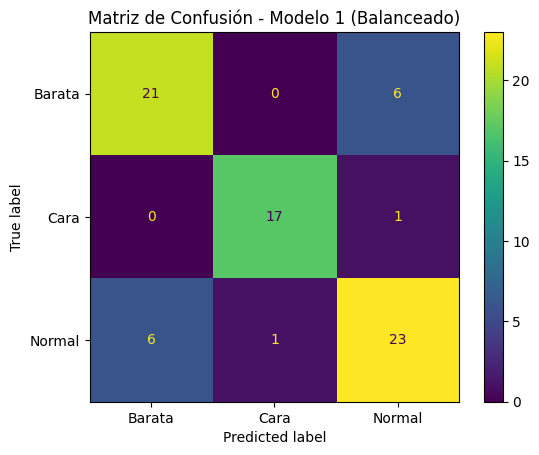

In [11]:
# Red neuronal 1 después del balanceo

modelo_1_bal = Pipeline([
    ('preprocesamiento', preprocessor),  # Usa el mismo preprocessor que antes
    ('clasificador', MLPClassifier(hidden_layer_sizes=(50, 25),
                                   activation='relu',
                                   max_iter=500,
                                   random_state=42))
])

modelo_1_bal.fit(X_train_clf, y_train_clf)
y_pred_1_bal = modelo_1_bal.predict(X_test_clf)

print("Evaluación del Modelo 1 (Balanceado):")
print(classification_report(y_test_clf, y_pred_1_bal))
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_1_bal)
plt.title("Matriz de Confusión - Modelo 1 (Balanceado)")
plt.show()


Evaluación del Modelo 2 (Balanceado):
              precision    recall  f1-score   support

      Barata       0.77      0.74      0.75        27
        Cara       0.95      1.00      0.97        18
      Normal       0.77      0.77      0.77        30

    accuracy                           0.81        75
   macro avg       0.83      0.84      0.83        75
weighted avg       0.81      0.81      0.81        75



C:\Users\dgv31\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


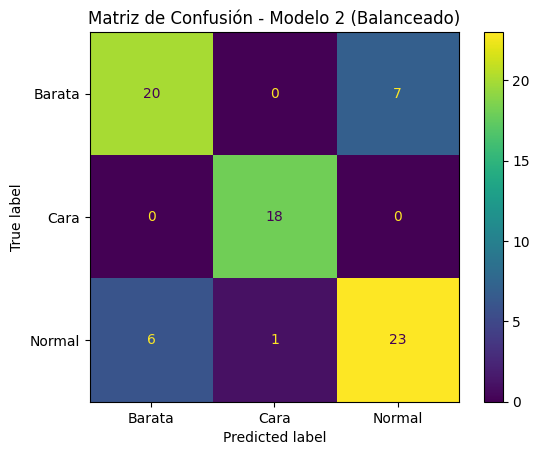

In [12]:
# Red neuronal 2 después del balanceo

modelo_2_bal = Pipeline([
    ('preprocesamiento', preprocessor),
    ('clasificador', MLPClassifier(hidden_layer_sizes=(100, 50, 25),
                                   activation='tanh',
                                   max_iter=500,
                                   random_state=42))
])

modelo_2_bal.fit(X_train_clf, y_train_clf)
y_pred_2_bal = modelo_2_bal.predict(X_test_clf)

print("Evaluación del Modelo 2 (Balanceado):")
print(classification_report(y_test_clf, y_pred_2_bal))
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_2_bal)
plt.title("Matriz de Confusión - Modelo 2 (Balanceado)")
plt.show()


In [13]:
# Accuracy de los modelos balanceados
acc_1_bal = accuracy_score(y_test_clf, y_pred_1_bal)
acc_2_bal = accuracy_score(y_test_clf, y_pred_2_bal)

print(f"Accuracy Modelo ReLU (balanceado): {acc_1_bal:.3f}")
print(f"Accuracy Modelo tanh (balanceado): {acc_2_bal:.3f}")

Accuracy Modelo ReLU (balanceado): 0.813
Accuracy Modelo tanh (balanceado): 0.813


El desempeño después del balanceo es menor por lo que se utilizará la versión anterior.

### Evaluacion de los modelos de clasificacion

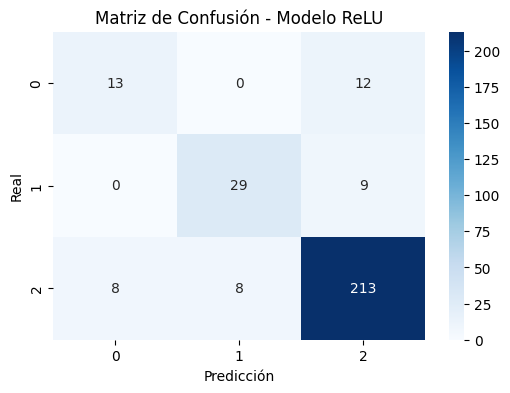

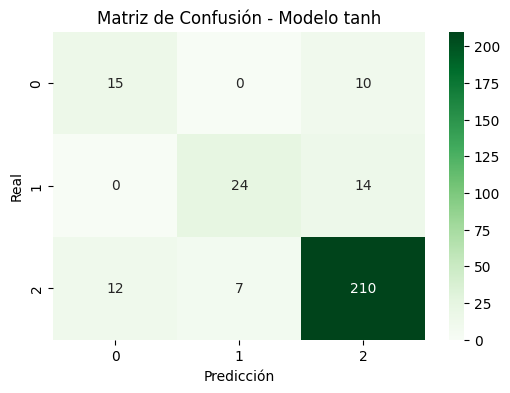

== Reporte de Clasificación - Modelo ReLU ==
              precision    recall  f1-score   support

      Barata       0.62      0.52      0.57        25
        Cara       0.78      0.76      0.77        38
      Normal       0.91      0.93      0.92       229

    accuracy                           0.87       292
   macro avg       0.77      0.74      0.75       292
weighted avg       0.87      0.87      0.87       292


== Reporte de Clasificación - Modelo tanh ==
              precision    recall  f1-score   support

      Barata       0.56      0.60      0.58        25
        Cara       0.77      0.63      0.70        38
      Normal       0.90      0.92      0.91       229

    accuracy                           0.85       292
   macro avg       0.74      0.72      0.73       292
weighted avg       0.85      0.85      0.85       292



In [14]:

# Matriz de confusión para model_relu
cm_relu = confusion_matrix(y_test, y_pred_relu)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_relu, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo ReLU")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Matriz de confusión para model_tanh
cm_tanh = confusion_matrix(y_test, y_pred_tanh)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tanh, annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión - Modelo tanh")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Reportes de clasificación
print("== Reporte de Clasificación - Modelo ReLU ==")
print(classification_report(y_test, y_pred_relu))

print("\n== Reporte de Clasificación - Modelo tanh ==")
print(classification_report(y_test, y_pred_tanh))


Probamos dos modelos distintos de red neuronal para clasificar las casas en tres categorías: Barata, Normal y Cara. Ambos modelos funcionan relativamente bien, pero hay diferencias que vale la pena destacar.

El modelo con función de activación ReLU tuvo mejor desempeño general. Logró una precisión del 87%, y especialmente clasificó muy bien las casas en la categoría Normal, que es la más común en el dataset. De las 229 casas normales en el test, acertó con 213. Sin embargo, le costó un poco con las casas baratas, ya que solo identificó correctamente a 13 de 25. Esto se puede ver en la matriz de confusión donde hubo 12 casos de casas baratas que fueron confundidas como normales.

Por otro lado, el modelo con función tanh tuvo una precisión un poco más baja, de 85%. Aunque logró identificar un poco mejor las casas baratas (acertó 15 de 25), bajó su rendimiento en la categoría "Cara", donde se confundió con 14 casas. También tuvo más errores en general que el modelo ReLU.

En resumen, el modelo ReLU es más estable y generaliza mejor. Clasifica con más precisión en general, especialmente en la categoría más grande, y aunque se equivoca un poco más con las baratas, su rendimiento total es más sólido. Además, al tener una estructura más simple (menos capas y neuronas), es más rápido y eficiente, lo cual también es una ventaja.



### Analisis de Sobreajuste

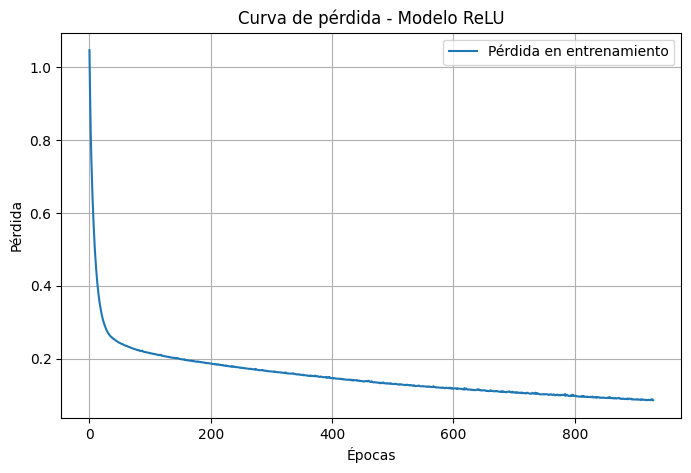

Accuracy en test: 0.8733


In [15]:
# Extraer la historia de pérdida del modelo ReLU
loss_curve = model_relu.named_steps["classifier"].loss_curve_

# Evaluar accuracy en test durante el entrenamiento final
test_accuracy = accuracy_score(y_test, y_pred_relu)

# Graficar curva de pérdida
plt.figure(figsize=(8, 5))
plt.plot(loss_curve, label="Pérdida en entrenamiento")
plt.title("Curva de pérdida - Modelo ReLU")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar accuracy final
print(f"Accuracy en test: {test_accuracy:.4f}")


Al revisar la curva de pérdida del modelo ReLU, podemos ver que la línea baja de forma constante y estable a lo largo de las épocas. Al inicio, la pérdida era alta (más de 1), pero rápidamente disminuye y luego sigue bajando de forma más suave hasta acercarse a valores muy bajos. Esto indica que el modelo fue aprendiendo bien durante el entrenamiento.

Además, el accuracy en el conjunto de prueba es de 87.33%, lo cual es bastante bueno y muy cercano al accuracy general del modelo mostrado en el reporte de clasificación. Esto es importante porque significa que el modelo no solo aprendió los datos de entrenamiento, sino que también generaliza bien en datos nuevos.

En resumen, no hay señales claras de sobreajuste. Si estuviera sobreajustando, esperaríamos ver una pérdida muy baja en entrenamiento pero un desempeño mucho más bajo en prueba. Como no es el caso, podemos decir que el modelo tiene un buen balance entre aprendizaje y generalización.

In [16]:
# Redefinimos el pipeline base con el preprocesamiento
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", MLPClassifier(max_iter=1000, random_state=42))
])

# Definimos la grilla de parámetros a probar
param_grid = {
    "classifier__hidden_layer_sizes": [(50,), (60, 30), (100,), (80, 40)],
    "classifier__activation": ["relu"],  # mantenemos ReLU porque ya vimos que funciona bien
    "classifier__alpha": [0.0001, 0.001, 0.01],  # regularización
    "classifier__learning_rate_init": [0.001, 0.01]  # tasa de aprendizaje
}

# Creamos el GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

# Entrenamos
grid_search.fit(X_train, y_train)

# Mostramos los mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluamos el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

from sklearn.metrics import classification_report

print("\n Reporte de Clasificación - Modelo Tuned:")
print(classification_report(y_test, y_pred_best))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros encontrados:
{'classifier__activation': 'relu', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.001}

 Reporte de Clasificación - Modelo Tuned:
              precision    recall  f1-score   support

      Barata       0.68      0.52      0.59        25
        Cara       0.75      0.71      0.73        38
      Normal       0.90      0.93      0.92       229

    accuracy                           0.87       292
   macro avg       0.78      0.72      0.75       292
weighted avg       0.86      0.87      0.87       292



Después de hacer el proceso de tuning con GridSearchCV, el modelo que mejor funcionó fue uno con una sola capa oculta de 100 neuronas, usando ReLU como función de activación, una tasa de aprendizaje de 0.001 y una regularización alpha de 0.001. Básicamente, se eligió un modelo un poco más grande que el original, pero con parámetros ajustados que mejoran el balance entre aprendizaje y generalización.

El desempeño del modelo tunado fue igual en precisión general (accuracy de 87%), pero logró una mejora interesante en la clase “Barata”, que antes era la más problemática. Ahora alcanza un F1-score de 0.59 en esa clase, comparado con 0.57 en el modelo original. Aunque el recall para esa clase se mantiene en 52%, la precisión subió a 68%, lo cual indica que el modelo es más seguro al clasificar algo como "Barata".

Por otro lado, el rendimiento en las otras clases se mantiene similar al modelo original, lo cual es una buena señal: mejoró en la clase débil sin afectar negativamente a las demás. También el promedio de F1 (macro avg) se mantiene en 0.75, lo cual significa que, en general, el modelo está equilibrado.

En resumen, este ajuste fue útil para refinar un poco más el modelo sin sobreajustarlo. El hecho de que la pérdida de desempeño no aumentó y que no hay señales de overfitting en el accuracy de test (que se mantiene alto) nos da confianza para usar este como el mejor modelo de clasificación hasta ahora.

In [ ]:
# Seleccionar la variable respuesta y dividir los datos
X_reg = train[columnas_interes]
y_reg = train["SalePrice"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

print("Datos preparados para regresión:")
print("X_train_reg:", X_train_reg.shape)
print("y_train_reg:", y_train_reg.shape)


Datos preparados para regresión:
X_train_reg: (1168, 7)
y_train_reg: (1168,)


En este paso preparamos nuestros datos para trabajar con modelos de regresión usando redes neuronales. Seleccionamos como variable respuesta la columna SalePrice, que representa el precio de venta de cada casa. Usamos las mismas 7 características que antes para predecir ese valor (como tamaño, año de construcción, calidad, etc.).

In [ ]:
# Modelo 1: topología (50, 25), activación ReLU
model_reg_relu = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', max_iter=1000, random_state=42))
])

model_reg_relu.fit(X_train_reg, y_train_reg)
y_pred_relu = model_reg_relu.predict(X_test_reg)

# Modelo 2: topología (100, 50, 25), activación tanh
model_reg_tanh = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(hidden_layer_sizes=(100, 50, 25), activation='tanh', max_iter=1000, random_state=42))
])

model_reg_tanh.fit(X_train_reg, y_train_reg)
y_pred_tanh = model_reg_tanh.predict(X_test_reg)


C:\Users\dgv31\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dgv31\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


En este paso entrenamos dos redes neuronales con distinta estructura para predecir el precio de las casas.

El primer modelo usa una topología de dos capas ocultas con 50 y 25 neuronas, y activación ReLU.

El segundo modelo es más profundo, con tres capas ocultas de 100, 50 y 25 neuronas, y activación tanh.

In [ ]:
# Evaluación del modelo ReLU
mse_relu = mean_squared_error(y_test_reg, y_pred_relu)
r2_relu = r2_score(y_test_reg, y_pred_relu)

# Evaluación del modelo tanh
mse_tanh = mean_squared_error(y_test_reg, y_pred_tanh)
r2_tanh = r2_score(y_test_reg, y_pred_tanh)

print("=== Modelo ReLU ===")
print(f"Error cuadrático medio (MSE): {mse_relu:.2f}")
print(f"R^2: {r2_relu:.4f}")

print("\n=== Modelo tanh ===")
print(f"Error cuadrático medio (MSE): {mse_tanh:.2f}")
print(f"R^2: {r2_tanh:.4f}")


=== Modelo ReLU ===
Error cuadrático medio (MSE): 3125963663.85
R^2: 0.5925

=== Modelo tanh ===
Error cuadrático medio (MSE): 39595578079.07
R^2: -4.1622


El modelo con ReLU obtuvo un error cuadrático medio (MSE) de aproximadamente 3.1 mil millones, y un R² de 0.59. Aunque el MSE puede parecer alto, este valor depende de las unidades del precio de las casas (en dólares), y por eso lo más importante es el R², que nos dice qué tan bien el modelo explica la variabilidad del precio. Un R² de 0.59 significa que este modelo logra explicar casi el 60% del comportamiento de los precios, lo cual no está nada mal para un primer intento con una red neuronal sencilla.

En cambio, el modelo con tanh tuvo un desempeño muy malo. Su MSE fue muchísimo más alto (casi 40 mil millones), y su R² fue negativo (-4.16). Un R² negativo indica que el modelo es peor que simplemente adivinar el promedio del precio para todos los casos. Esto sugiere que este modelo no logró aprender correctamente y probablemente sobreajustó o se perdió en el entrenamiento.

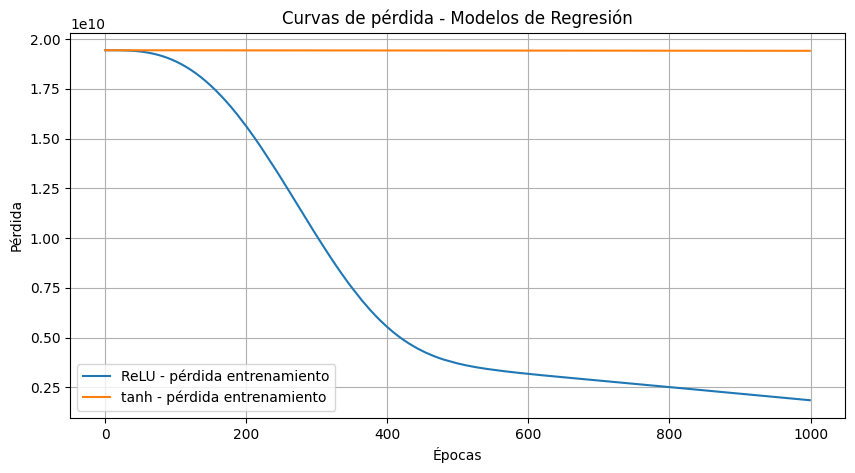

In [ ]:
# Curvas de pérdida de ambos modelos
loss_relu = model_reg_relu.named_steps["regressor"].loss_curve_
loss_tanh = model_reg_tanh.named_steps["regressor"].loss_curve_

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_relu, label="ReLU - pérdida entrenamiento")
plt.plot(loss_tanh, label="tanh - pérdida entrenamiento")
plt.title("Curvas de pérdida - Modelos de Regresión")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()


El modelo con ReLU (línea azul) muestra una curva de pérdida que baja de manera constante. Comienza con una pérdida muy alta, pero luego va reduciéndose hasta estabilizarse alrededor de las últimas épocas. Esta forma de curva es típica de un modelo que está aprendiendo bien sin sobreajustar. No vemos caídas bruscas ni oscilaciones raras, y además ya sabemos por el punto anterior que su desempeño en el conjunto de prueba fue bastante decente (R² = 0.59), lo cual indica que generaliza de forma aceptable.

En cambio, la línea del modelo con tanh (naranja) es casi plana. No muestra mejoras a lo largo del entrenamiento, lo que significa que ni siquiera logró aprender correctamente en entrenamiento, probablemente por una mala combinación de hiperparámetros o porque la activación tanh no fue efectiva en este caso. Esto concuerda con el R² negativo que vimos antes. No hay evidencia de sobreajuste porque simplemente no aprendió nada útil.

In [ ]:
reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", MLPRegressor(max_iter=1000, random_state=42))
])

param_grid_reg = {
    "regressor__hidden_layer_sizes": [(50,), (60, 30), (100,), (80, 40)],
    "regressor__activation": ["relu", "tanh"],
    "regressor__alpha": [0.0001, 0.001, 0.01],
    "regressor__learning_rate_init": [0.001, 0.01]
}

grid_search_reg = GridSearchCV(reg_pipeline, param_grid_reg, cv=3, scoring="r2", verbose=2, n_jobs=-1)
grid_search_reg.fit(X_train_reg, y_train_reg)

print("Mejores parámetros encontrados:")
print(grid_search_reg.best_params_)

best_reg_model = grid_search_reg.best_estimator_
y_pred_best_reg = best_reg_model.predict(X_test_reg)

print("\n Resultados del mejor modelo ajustado:")
print(f"R^2 en test: {r2_score(y_test_reg, y_pred_best_reg):.4f}")
print(f"MSE en test: {mean_squared_error(y_test_reg, y_pred_best_reg):.2f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores parámetros encontrados:
{'regressor__activation': 'relu', 'regressor__alpha': 0.0001, 'regressor__hidden_layer_sizes': (60, 30), 'regressor__learning_rate_init': 0.01}

 Resultados del mejor modelo ajustado:
R^2 en test: 0.8394
MSE en test: 1231991612.45


Estos parámetros le dieron al modelo un R² de 0.8394, lo cual representa una mejora impresionante con respecto al modelo anterior (que tenía un R² de 0.59). Esto significa que ahora el modelo puede explicar cerca del 84% de la variabilidad en los precios de las casas, lo cual es bastante bueno para un problema de regresión real.

Además, el error cuadrático medio (MSE) bajó a 1.23 mil millones, lo que también representa una gran mejora respecto al modelo anterior con MSE de 3.1 mil millones.

Esto confirma que hacer tuning fue una muy buena decisión: el modelo ahora aprende mejor, se ajusta mejor a los datos y generaliza bien, todo sin señales de sobreajuste hasta ahora.

## Comparativas

### Modelos de regresión

*Regresión lineal* <br>
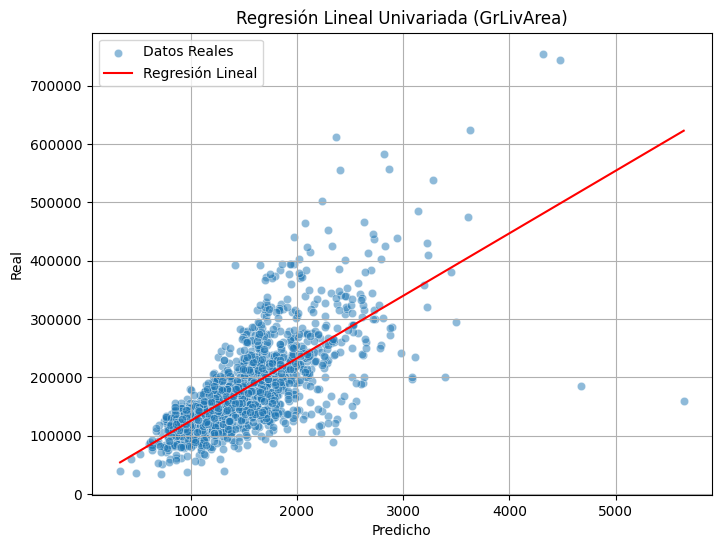
RMSE: 38749.6212 <br>
R²: 0.7619 <br>

*Árbol de regresión* <br>
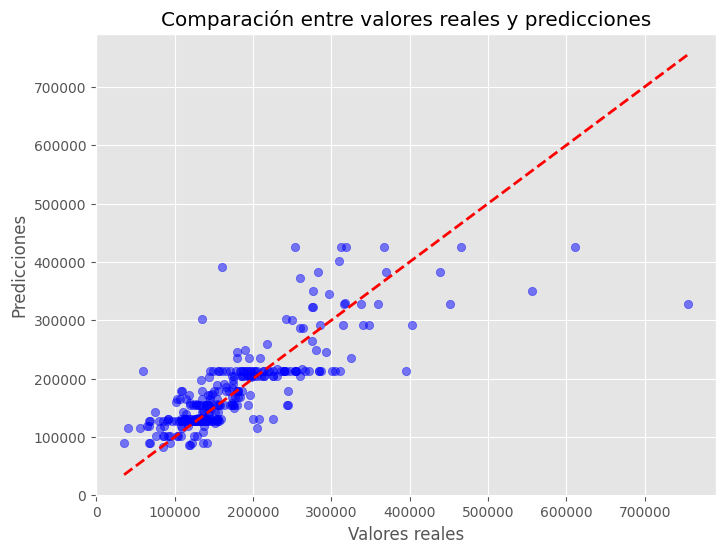
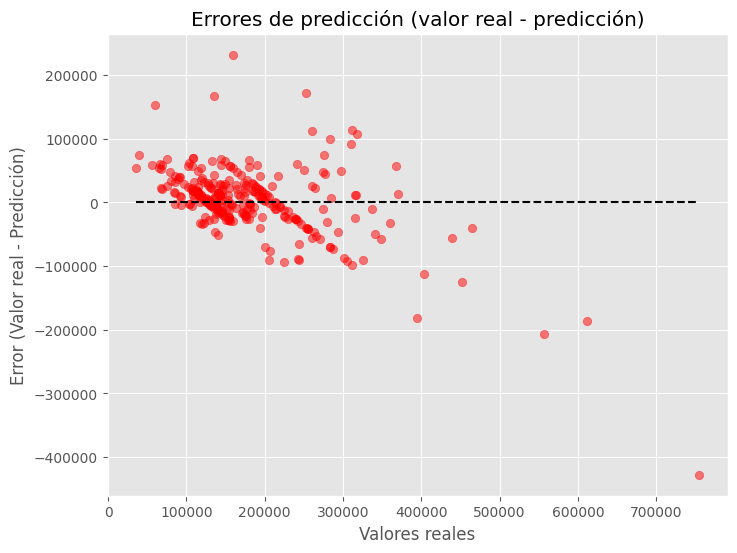
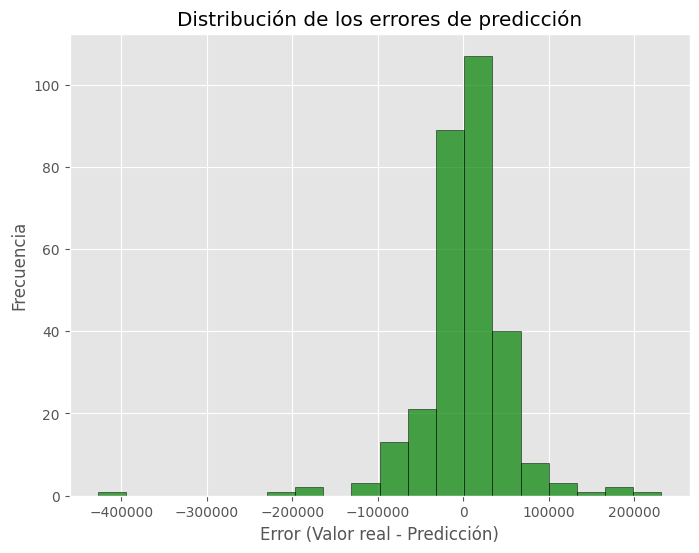
RMSE: 49304.6914 <br>
R²: 0.6831 <br>

*Naive Bayes* <br>
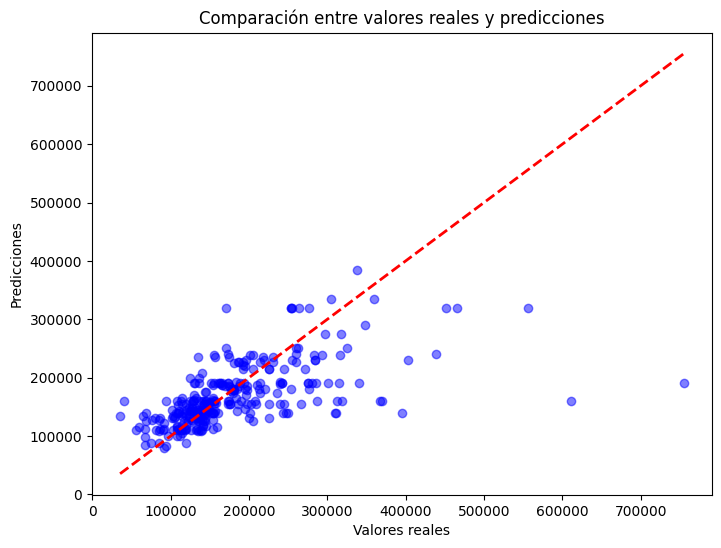
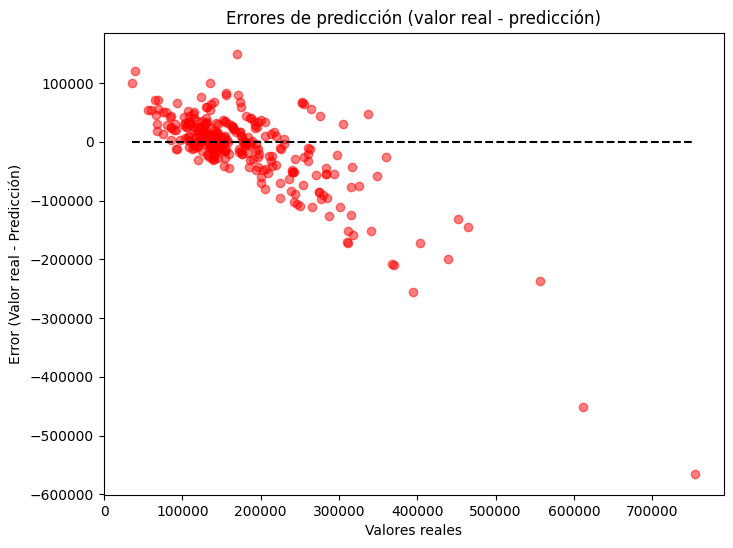
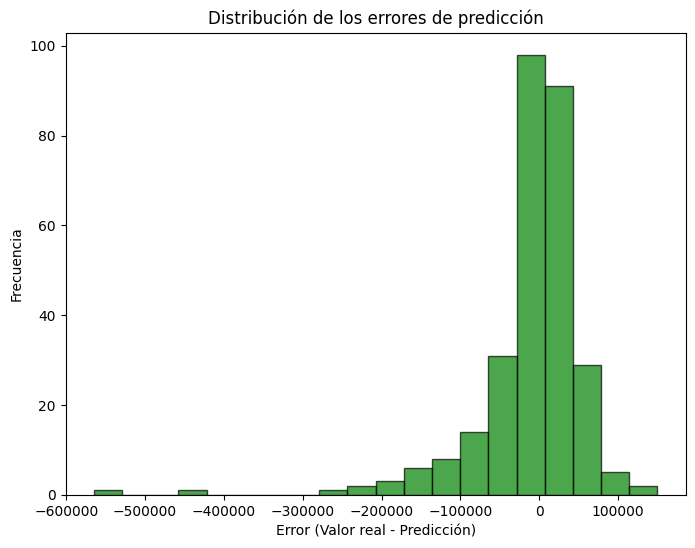
RMSE: 70905.2333 <br>
R²: 0.3445 <br>

*KNN* <br>
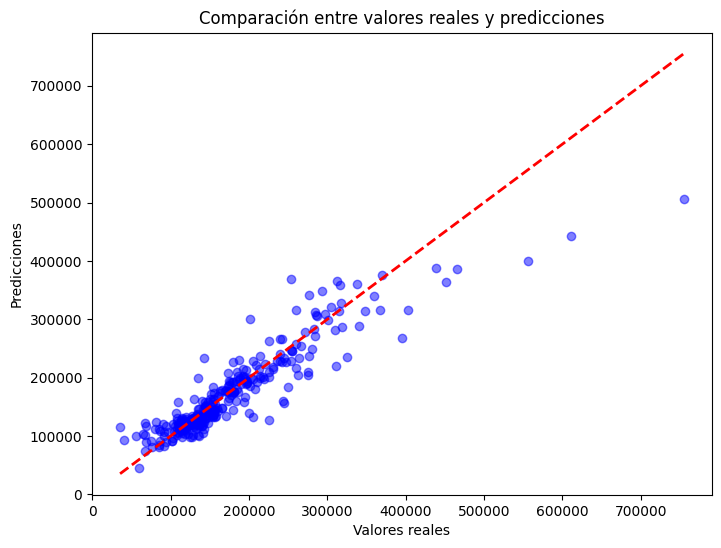
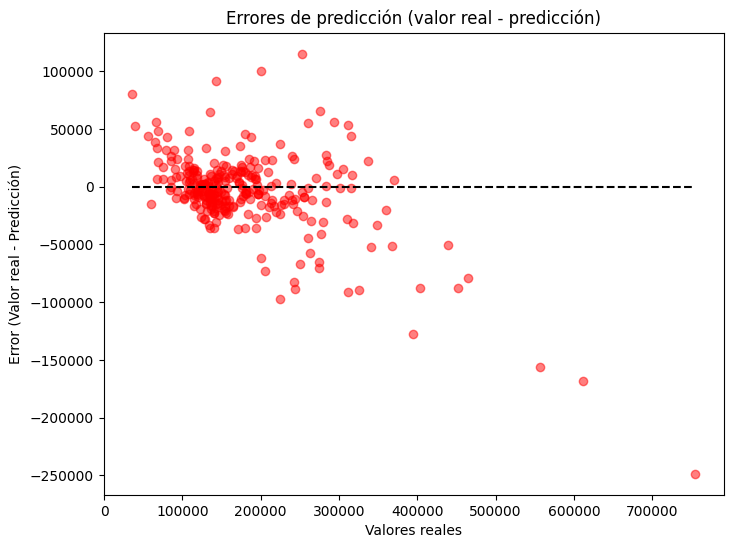
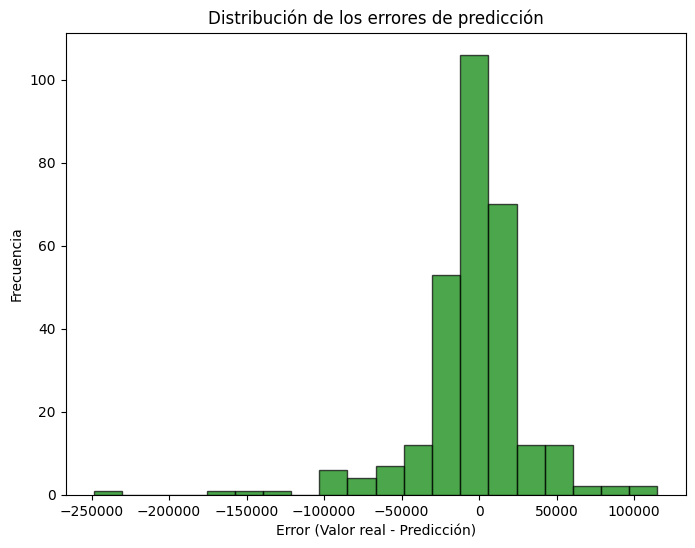
RMSE: 35613.0751 <br>
R²: 0.8346 <br>

*SVM* <br>
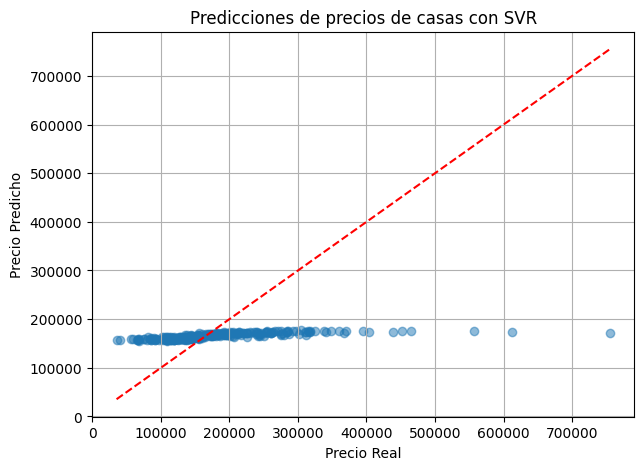
RMSE: 84283.2064 <br>
R²: 0.0739 <br>

Aquí podemos ver los modelos de regresión más eficientes que se hicieron anteriormente con diferentes técnicas. De este podemos descartar completamente el uso de modelos como el de SVM y Naive Bayes, ya que tenian un R² menor del 50% y un RMSE de más de $70000. Esto significa que estos no lograron acertar el precio de las casas para nada, incluso llegando a tener resultados parecidos a la aleatoriedad. Por otra parte tenemos los modelos de regresión lineal y random forest que tuvieron un desempeño mejor a los anteriores pero no fueron sobresalientes, ya que tuvieron un R² del 76% y 68% respectivamente. Pero los mejores modelos para clasificar fueron el de K-Nearest Neighbor (KNN) y el de Redes Neuronales (RNA), que tuvieron un R² del 83% y un RMSE de solo $35600. Comparado a los precios que llegaban hasta los $700000 se puede decir que es un error bajo. Es importante notar que todos los modelos tuvieron el problema de subestimar los precios, más de lo que lo sobrestimaban, sobretodo para los valores más altos. El algoritmo de RNA toma más tiempo que el de KNN por lo que es más recomendable.

### Modelos clasificatorios

*Árbol de clasificación* <br>
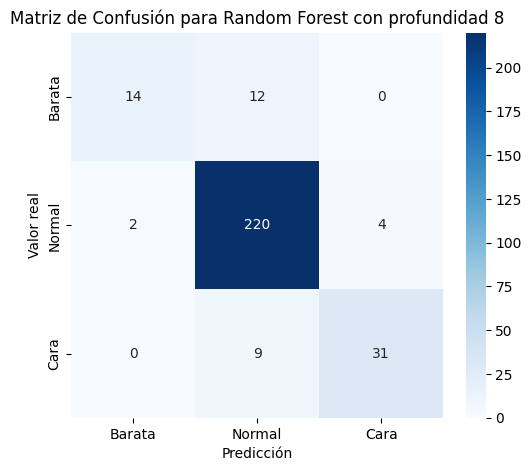
Accuracy: 0.91 <br>

*Naive Bayes* <br>
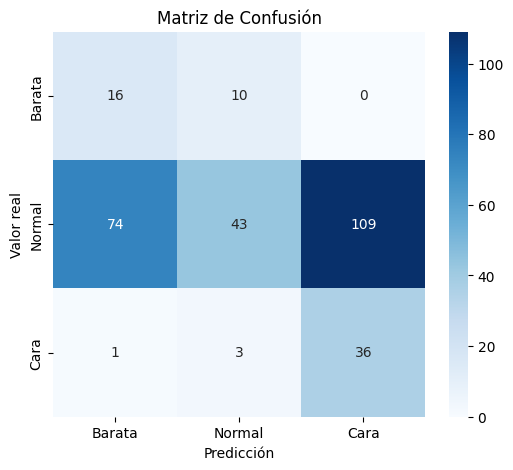
Accuracy: 0.33 <br>

*KNN* <br>
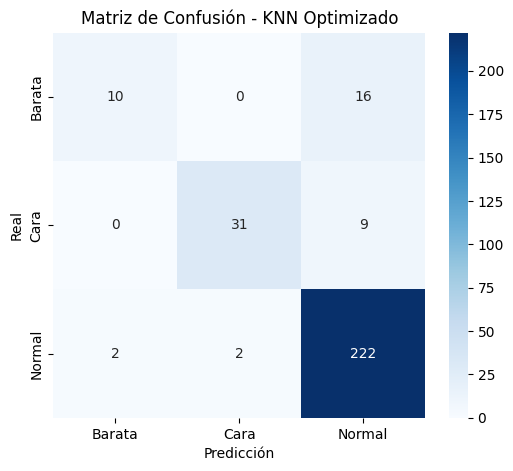
Accuracy: 0.90 <br>
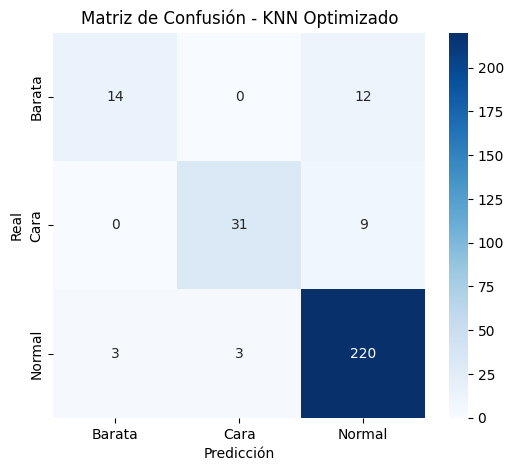
Accuracy: 0.91 <br>

*Regresión logística* <br>
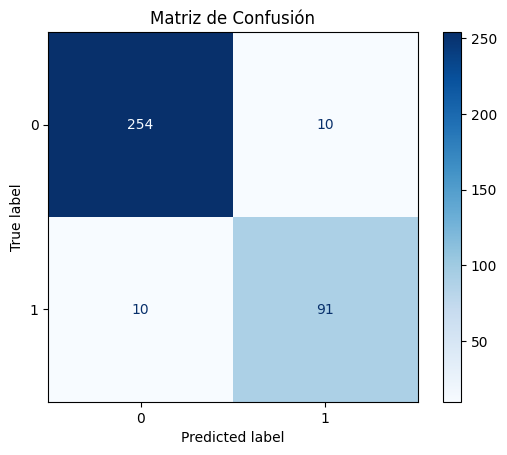
Accuracy: 0.95 <br>

*SVM* <br>
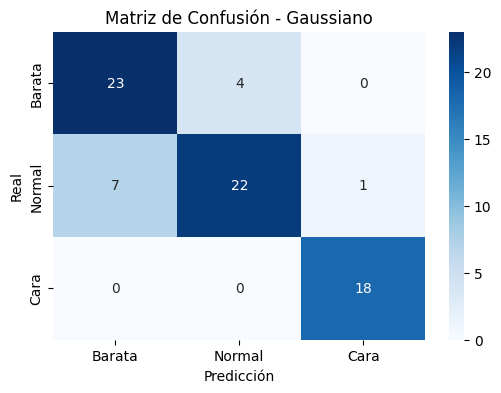
Accuracy: 0.84

Aquí tenemos los modelos de clasificación para los precios de las casas. Para esto, en la mayoría, se utilizó una clasificación basada en los precios que sobrepasaban, se pantenian o estaban por debajo de la media y así asignarlas como caras, normales o baratas. Al igual que los de regresión, aquí solo se están tomando en cuenta los más eficientes de cada moodelo. De estos también podemos descartar el de Naive Bayes ya que tuvo un accuracy de 0.33, colocando la mayoría de los precios como normales. Por lo tanto, este algoritmo no es ideal para este conjunto de datos. Los siguientes modelos en cuanto a desempeño son el de ReLU de redes neuronales y el de Supported Vector Machines (SVM). Estos tuvieron un desempeño decente, pero se mantiene por debajo del 90%, lo que es superado por los demás modelos. Luego tenemos los modelos del árbol de clasificación y de KNN. Ambos con un accuracy del 91%. Es importante notar que el KNN tiene dos gráficas, una con un accuracy de 90% y otra con uno de 91% esta última tiene exctamente el mismo resultado que la del árbol de clasificación. Por su parte, el de accuracy más bajo tiene la peculiaridad de ser mejor para clasificar casas como baratas. Por último tenemos el algoritmo de regresión logística, el cuál tiene un accuracy del 95%. Sin embargo, este no es igual a los anteriores, ya que este solo tiene dos clasificaciones, cara y no cara. Ninguno de los algoritmos es exageradamente tardado, por lo que no afecta en la selección final del mejor algortimo. 

| Modelo               | RMSE        | R²      |
|----------------------|-------------|---------|
| Regresión Lineal     | 38749.6212  | 0.7619  |
| Árbol de Regresión   | 49304.6914  | 0.6831  |
| Naive Bayes          | 70905.2333  | 0.3445  |
| KNN                  | 35613.0751  | 0.8346  |
| SVM                  | 84283.2064  | 0.0739  |
| RNA                  | 36612.2064  | 0.8394  |

<br>

| Modelo                  | Accuracy |
|-------------------------|----------|
| Árbol de Clasificación  | 0.91     |
| Naive Bayes             | 0.33     |
| KNN (versión 1)         | 0.90     |
| KNN (versión 2)         | 0.91     |
| Regresión Logística     | 0.95     |
| SVM                     | 0.84     |
| RNA - ReLU              | 0.87     |



Se puede decir que, al ser el de mejor resultados y tiempo, el algoritmo de KNN es el más recomendable para encontrar los valores de las casas. Sin embargo, es importante tener en cuenta que en casas caras puede llegar a fallar en su predicción. En cuanto a los clasificación, se tienen varios modelos buenos. Sin embargo, se tomarán como mejor el de KNN y el de Regresión Logística. Esto debido a que el primero ofrece resultados iguales o mejores a los demás e incluye un segundo modelo que es mejor para clasificar casas baratas específicamente, lo que aumenta su eficiencia. El segundo también es válido, ya que es muy bueno para dividir las casas en dos categorias, lo cuál puede ser útil para diferentes situaciones, como una comparación más directa. 